## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,recall_score
from sklearn import tree

# For tuning the model
from sklearn.model_selection import GridSearchCV

## To ignore warnings
#import warnings
#warnings.filterwarnings("ignore")

## Load Data

In [2]:
df_raw = pd.read_csv('./data/train.csv')

In [3]:
## Basic Info in Dataset

In [4]:
df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Checking unique values in each column
df_raw.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

## Drop Unnecessary Columns

In [6]:
# Dropping the columns 

## TODO - would be better to keep cabin as a categorical variable 
 ## based on the geometry of the actual boat
df_filtered=df_raw.drop(['PassengerId','Name','Ticket', 'Embarked', 'Cabin'],axis=1)

In [7]:
## Split into Numerical / Categorical Columns
cols_num = ['Age', 'SibSp', 'Parch', 'Fare']
cols_cat = ['Survived', 'Pclass', 'Sex']

In [8]:
## Exploratory Analysis and Preprocessing

In [9]:
# Checking summary statistics
df_filtered[cols_num].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


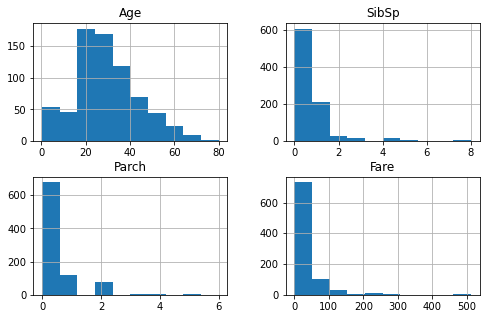

In [10]:
# Creating histograms
df_filtered[cols_num].hist(figsize=(8,5))
plt.show()

In [11]:
# Printing the % sub categories of each category
for i in cols_cat:
    print(df_filtered[i].value_counts(normalize=True))
    print('*'*40)

0    0.616162
1    0.383838
Name: Survived, dtype: float64
****************************************
3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64
****************************************
male      0.647587
female    0.352413
Name: Sex, dtype: float64
****************************************


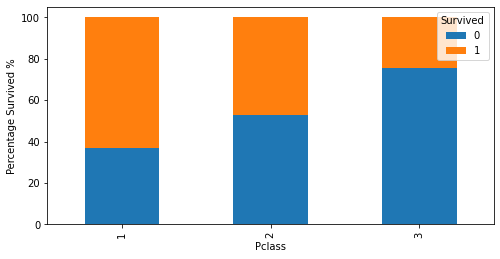

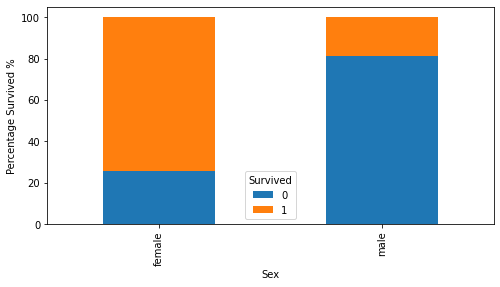

In [12]:
for i in cols_cat:
    if i!='Survived':
        (pd.crosstab(df_filtered[i],df_filtered['Survived'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
        plt.ylabel('Percentage Survived %')

In [13]:
# Mean of numerical variables grouped by attrition
df_filtered.groupby(['Survived'])[cols_num].mean()

,Age,SibSp,Parch,Fare
Survived,,,,
0,30.626179,0.553734,0.329690,22.117887
1,28.343690,0.473684,0.464912,48.395408


<AxesSubplot:>

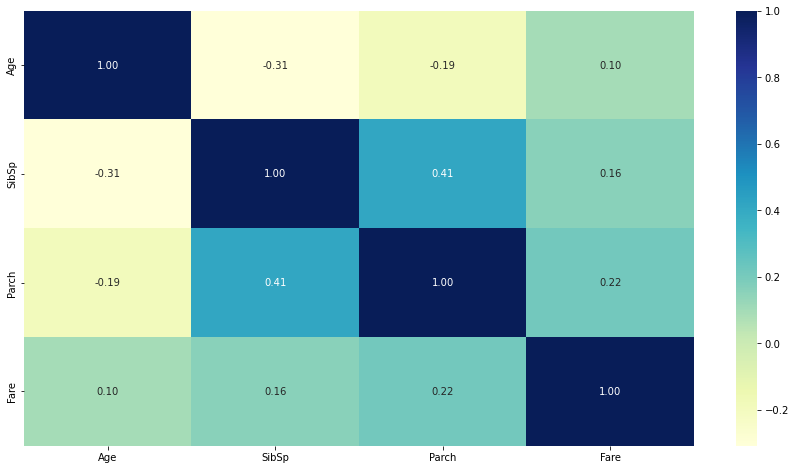

In [14]:
# Plotting the correlation between numerical variables
plt.figure(figsize=(15,8))
sns.heatmap(df_filtered[cols_num].corr(),annot=True, fmt='0.2f', cmap='YlGnBu')

In [15]:
# Data Preparation

In [16]:
## Map female=1, male=0
dict_sex = {'female': 1, 'male': 0}
df_filtered['Sex'] = df_filtered.Sex.map(dict_sex)

In [17]:
# Separating target variable and other variables
Y= df_filtered.Survived
X= df_filtered.drop(columns = ['Survived'])

In [18]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1, stratify = Y)

In [19]:
# Scaling the data
sc=StandardScaler()

# Fit_transform on train data
X_train_scaled=sc.fit_transform(X_train)
X_train_scaled=pd.DataFrame(X_train_scaled, columns=X.columns)

# Transform on test data
X_test_scaled=sc.transform(X_test)
X_test_scaled=pd.DataFrame(X_test_scaled, columns=X.columns)

In [20]:
## Create a Metric Evaluation Function

In [21]:
# Creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Survive', 'Survive'], yticklabels=['Not Survive', 'Survive'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [22]:
# Logistic Regression

In [23]:
# Fitting logistic regression model
lg=LogisticRegression()
lg.fit(X_train_scaled,y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').